In [1]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
from astropy.io import fits
import pandas as pd
import seaborn as sns 
import itertools

In [2]:
zmin = 0.0
zmax = 2.3

mmin = 15.0
mmax = 26.0
nm = 11

fac = 20
nz_coarse = 75
nz_fine = nz_coarse*fac

z_grid_coarse = np.linspace(zmin, zmax, nz_coarse)
z_grid_fine = np.linspace(zmin, zmax, nz_fine)
ref_mag_grid = np.linspace(mmin, mmax, nm)

filters = ['g', 'r', 'i', 'z']
reffilter = 2

# ellipticals = ['El_B2004a.sed']
# spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed']
# irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed','ssp_25Myr_z008.sed','ssp_5Myr_z008.sed']

ellipticals = ['El_cww_capak.sed']
spirals = ['Sbc_cww_capak.sed','Scd_cww_capak.sed']
irregulars = ['Im_cww_capak.sed','SB3_kin_capak.sed','SB2_kin_capak.sed']

template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

nt = len(template_names)

# Read and clean catalogs

26406


/home/juancordero/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/juancordero/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


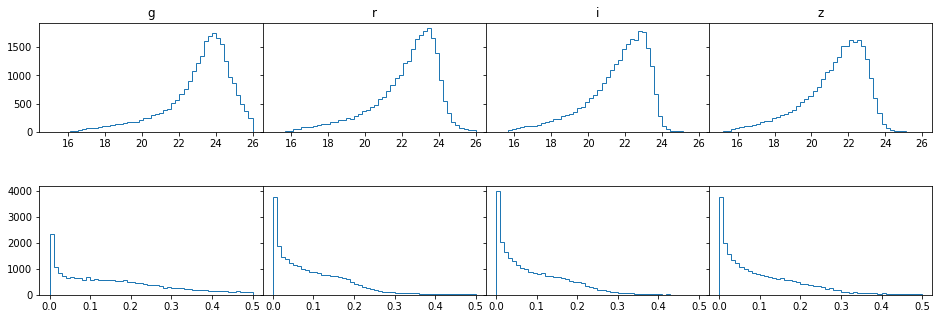

In [3]:
catalog = fits.open('DES_Y1_GOLD/Y1_GOLD_BPZ_100000.fits')[1]
data = catalog.data

# We only use objects which are not flagged to be excluded from analysis in GOLD
data = data[:30000]
data = data[data['FLAGS_GOLD'] == 0]

# We apply a few arbitrary cuts to generate a catalog of well behaved objects

fluxlim_ref = 10**(-0.4*(mmax-30))
snr_cut = 0.2 # S/N > 5

flux_name = 'mof_flux_'
fluxerr_name = 'mof_fluxerr_'
mag_name = 'mag_'
magerr_name = 'magerr_'

# We keep everything brighter than mag = 26 in reference band
# We do a S/N cut based on snr_cut
# data = data[data[flux_name+filters[reffilter]] > fluxlim_ref]
# data = data[data[magerr_name+filters[reffilter]] <= snr_cut]
    
nobj = data.size
print(nobj)

fluxes = np.zeros((len(filters), nobj))
fluxerrs = np.zeros((len(filters), nobj))
mags = np.zeros((len(filters), nobj))
magerrs = np.zeros((len(filters), nobj))

redshifts = data['z_bpz']
types = data['template_type']

for i, b in enumerate(filters):
    fluxes[i] = np.array(data[flux_name+b])
    fluxerrs[i] = np.array(data[fluxerr_name+b])
    mags[i] = np.array(data[mag_name+b])
    magerrs[i] = np.array(data[magerr_name+b])

f, axes = plt.subplots(2, len(filters), figsize=(16,5), sharey='row')
for i,b in enumerate(filters):
    axes[0,i].hist(mags[i], range = (mmin, mmax), bins = 50, histtype='step')
    axes[1,i].hist(magerrs[i], bins = 50, histtype='step', range = (0,0.5))
    axes[0,i].set_title(b)
plt.subplots_adjust(wspace=0, hspace= 0.5)

/home/juancordero/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/juancordero/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


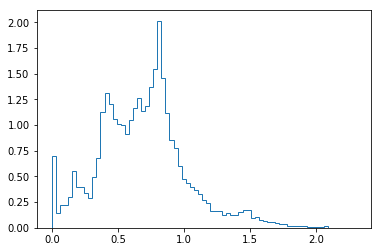

In [4]:
true_z = plt.hist(redshifts, range = (zmin,zmax), bins = nz_coarse, histtype = 'step', density = True)[0]

# Obtain the flux-redshift models

The observed photon flux is:

$$ F_{b,t} = \int_0^{\infty}\,\frac{L_t[\nu(1+z)]}{\nu}\,W_b(\nu)\,d\nu$$

Which is the number of photons per unit time per unit area observed trough a setup with instrumental response $W_b(\nu)$ from a source at redshift $z$ with restframe Spectral Energy Density (SED) $L_t[\nu]$

Changing variables from frequency to wavelength we have

$$\frac{d\nu}{d\lambda}L_t(\nu) = L_t(\lambda) \Rightarrow L_t(\nu) = -L_t(\lambda)\frac{\lambda^2}{c}$$

At the same time, $d\nu = \frac{-c}{\lambda^2}d\lambda$, and we have tabulated values for $W_b(\lambda)$

$$ F_{b,t} = \int_0^{\infty}\frac{\lambda}{c}\,L_t[\lambda(1+z)] \frac{-\lambda^2}{c} \,W_b(\lambda)\,\frac{-c}{\lambda^2} d\lambda  = \int_0^{\infty}\left[L_t[\lambda(1+z)]\,\lambda^2\right] \,\left[W_b(\lambda)\,\frac{1}{c\lambda}\right] d\lambda$$

In [5]:
# Approximate luminosity distance for flat LCDM
def DL(z):
    return np.exp(30.5 * z**0.04 - 21.7)


# We will now use the BPZ routines to load the flux-redshift model for each template.
# We'll have interpolated and discretized versions
nf = len(filters)

f_mod = np.zeros((nz_fine,nt,nf))                  # This is the fine version of the flux-redshift model
f_mod_interps = np.zeros((nt, nf), dtype=interp1d) # This basically allows us to evaluate at any z

lambdaRef = 7e3 # Wavelength at which the templates are normalized

for it in range(nt):
    seddata = np.genfromtxt('./seds/' + template_names[it] + '.sed')
    seddata[:, 1] *= seddata[:, 0]**2. # light speed in angstrom/s ?? What if I remove this...
    ref = np.interp(lambdaRef, seddata[:, 0], seddata[:, 1])
    seddata[:, 1] /= ref
    sed_interp = interp1d(seddata[:, 0], seddata[:, 1])
    
    for jf in range(nf):
        filter_data = np.genfromtxt('./filters/' + filters[jf] + '_DES_Y1.res')
#         filter_data = np.genfromtxt('./filters/' + filters[jf] + '.dat')
        xf, yf = filter_data[:, 0], filter_data[:, 1]
        yf /= xf  # divide by lambda
#         Only consider range where >1% max
        ind = np.where(yf > 0.01*np.max(yf))[0]
        lambdaMin, lambdaMax = xf[ind[0]], xf[ind[-1]]
        norm = np.trapz(yf, x=xf)
        
        for iz in range(nz_fine):
            opz = (z_grid_fine[iz] + 1.0)
            xf_z = np.linspace(lambdaMin / opz, lambdaMax / opz, num=5000)
            yf_z = interp1d(xf / opz, yf)(xf_z)
            ysed = sed_interp(xf_z)
            f_mod[iz, it, jf] = np.trapz(ysed * yf_z, x=xf_z) / norm
            f_mod[iz, it, jf] *= opz**2. / DL(z_grid_fine[iz])**2. / (4*np.pi)
#         This is an actual interpolator. Given any z value it will return the interpolation at that z
        f_mod_interps[it, jf] = InterpolatedUnivariateSpline(z_grid_fine, f_mod[:, it, jf])
        
f_mod_log = -2.5*np.log10(f_mod) # Flux-redshift model converted to magnitude-redshift model

These are the tracks generated by redshifting the templates, itegrating them over the filter response curve, and calculating the color by comparing the magnitudes of two consecutive filters.
On top of this, we plot the observed colors of galaxies tagged with a specific template in the GOLD catalogue.
Since the tagging is made considering an interpolation between templates, we group together all objects around the central value for the template.
Some of them seem to be in good agreement, but differences can be caused by the fact that the set of templates used by BPZv1 is possiby different, and the fliter response curves *could* be different aswell.

/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


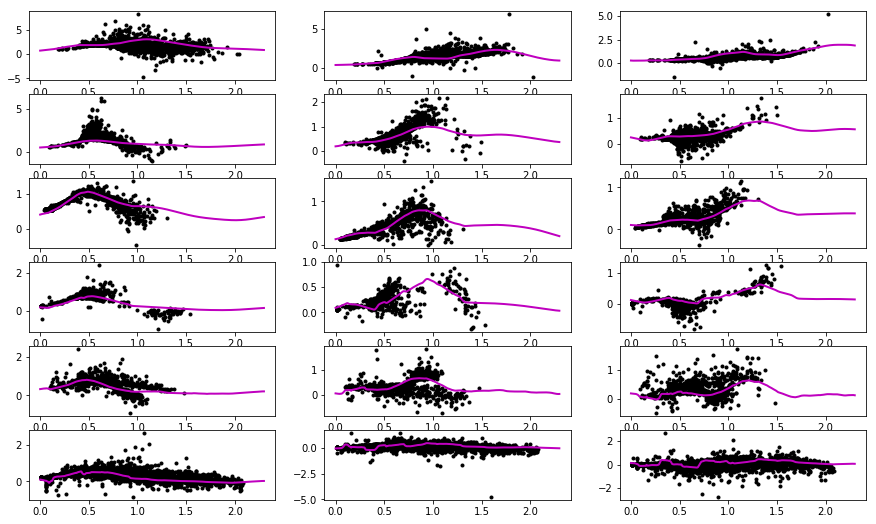

In [6]:
d_template = 0.0
f, axes = plt.subplots(nt, nf-1, figsize=(15,nt*1.5))

for i in range(nt):
    types_t = [(types >= i-d_template) & ((types <= i+d_template))]
    mags_t = mags.T[tuple(types_t)]
    redshift_t =  redshifts[tuple(types_t)]

    for band in range(nf-1):
        axes[i,band].plot(redshift_t, mags_t[:,band] - mags_t[:,band+1], '.', c = 'k')
        color = -2.5*np.log10(f_mod[:,i,band] / f_mod[:,i,band+1])
        axes[i,band].plot(z_grid_fine, color, lw=2, c='m')

This is a scale-free likelihood function, marginalizing over the scales of the fluxes, following the formulation presented in Benitez (2000)

In [7]:
# This is a scale-free likelihood function, marginalizing over the scale of the fluxes
# This follows the formulation presented in Benitez (2000)
def scalefree_flux_likelihood(f_obs, f_obs_var, f_mod, returnChi2=False):
    nz, nt, nf = f_mod.shape
    var = f_obs_var  # nz * nt * nf
    invvar = np.where(f_obs/var < 1e-6, 0.0, var**-1.0)   # nz * nt * nf
    FOT = np.sum(f_mod * f_obs * invvar, axis=2)  # nz * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)  # nz * nt
    FOO = np.dot(invvar, f_obs**2)  # nz * nt
    ellML = FOT / FTT
    chi2 = FOO - FOT**2.0 / FTT  # nz * nt
    like = np.exp(-0.5*chi2) / np.sqrt(FTT)  # nz * nt
    if returnChi2:
        return chi2 + FTT, ellML
    else:
        return like, ellML

In [8]:
# Let's use the same templates to compute the likelihood functions of all these objects
# Compute likelihood for each object

bpz_like_fine_multitypes = np.zeros((nobj, nz_fine, nt), dtype=float) # Binned liklihood at full resolution
bpz_like_multitypes = np.zeros((nobj, nz_coarse, nt), dtype=float) # Coarce binned likelihood
new_f_mod = f_mod[:,:,:] / f_mod.mean(axis=2)[:, :, None] # Why is this exactly?

for i in range(nobj):
    if i%1000 == 0:
        print(i, end=' ')
    # This scales both the errors and the fluxes to reasonable numbers.
    # The values change but relative peaks do not. It could be 1 as well and represent no change
    scafac = 1/np.mean(fluxes[:,i]) 
    ff, ellML = scalefree_flux_likelihood(scafac*fluxes[:,i], (scafac*fluxerrs[:,i])**2, new_f_mod)
    bpz_like_fine_multitypes[i,:,:] = ff # Fine resolution
    for kk in range(nz_coarse):
        bpz_like_multitypes[i,kk,:] = np.mean(ff[kk*fac:(kk+1)*fac,:], axis=0) # Re-bin

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 

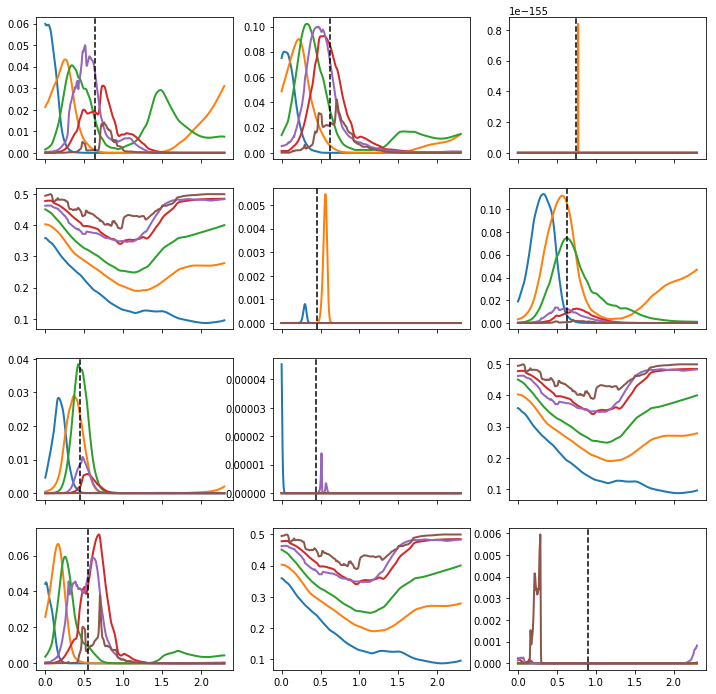

In [9]:
# plot likelihood function for a few randomly picked objects
# color coded by type.
fig2, axs = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=False)
axs = axs.ravel()
ri = np.random.choice(np.arange(nobj), axs.size, replace=False)
# ri = np.arange(12)
for i in range(len(ri)):
    theax = axs[i]
    theax.plot(z_grid_fine, bpz_like_fine_multitypes[ri[i],:,:], lw=2)
#     theax.plot(z_grid_coarse, bpz_like_multitypes[ri[i],:,:], lw=2,drawstyle='steps')
    theax.axvline(redshifts[ri[i]], ls='dashed', c='k')
#     theax.set_title(r'Likelihood $p(F|z,t)$')
#     theax.set_xlabel(r'Redshift $z$')

In [10]:
# Also need to multiply with gaussian likelihood for reference magnitude, since we will infer p(z, t, m)
def gauss_like_int(grid_edges, mus, sigmas):
    nobj = mus.size
    nz = grid_edges.size-1
    res = np.zeros((nobj, nz))
    fac = np.sqrt(2) * sigmas
    for iz, (zlo, zhi) in enumerate(zip(grid_edges[:-1], grid_edges[1:])):
        res[:,iz] = np.abs(-(erfc((zhi-mus)/fac) - erfc((zlo-mus)/fac))/2.0)
    return res

In [11]:
imag_grid_edges = np.linspace(mmin, mmax, num=nm+1)
imag_grid = (imag_grid_edges[1:] + imag_grid_edges[:-1])/2.0
bpz_like_ztm = np.zeros((nobj, nz_coarse, nt, nm), dtype=float)
imaglike = gauss_like_int(imag_grid_edges, mags[reffilter,:], magerrs[reffilter,:])
for i in range(nobj):
    bpz_like_ztm[i,:,:,:] = np.outer(bpz_like_multitypes[i,:,:], imaglike[i,:]).reshape((nz_coarse, nt, nm))
    
imaglocs = np.zeros((nobj,), dtype=int)
for iz, (zlo, zhi) in enumerate(zip(imag_grid_edges[:-1], imag_grid_edges[1:])):
    ind = np.logical_and(mags[reffilter] > zlo, mags[reffilter] <= zhi)
    if ind.sum()>0:
        imaglocs[ind] = iz

/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# Compute z_MAP in case it is useful, and also write likelihoods to 4 files
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

# Save each chunk of 4D python numpy array into files
nchunks = 4
lines_out = np.arange(nobj)#lines#np.arange(nobj_selec)
for i, ind in enumerate(chunks(lines_out, nchunks)):
    fname = 'bpz_DES_GOLD_Y1_ztm_'+str(nchunks)+'_'+str(i+1)+'.npy'
    np.save(fname, bpz_like_ztm[ind,:,:,:])

In [13]:
!mpirun -np 4 ./bayeshist.py bpz_DES_GOLD_Y1_ztm_4 1000

('Input parameters:', ['./bayeshist.py', 'bpz_DES_GOLD_Y1_ztm_4', '1000'])
Running on 4 cores
('Read file', 'bpz_DES_GOLD_Y1_ztm_4_4.npy', 'and found', 6602, 'objects')
('Read file', 'bpz_DES_GOLD_Y1_ztm_4_3.npy', 'and found', 6601, 'objects')
('Read file', 'bpz_DES_GOLD_Y1_ztm_4_2.npy', 'and found', 6602, 'objects')
('Read file', 'bpz_DES_GOLD_Y1_ztm_4_1.npy', 'and found', 6601, 'objects')
Broadcasted hbs
./bayeshist.py:103: RuntimeWarning: invalid value encountered in divide
  cumsumweights /= cumsumweights[-1,:]
./bayeshist.py:103: RuntimeWarning: invalid value encountered in divide
  cumsumweights /= cumsumweights[-1,:]
./bayeshist.py:103: RuntimeWarning: invalid value encountered in divide
  cumsumweights /= cumsumweights[-1,:]
./bayeshist.py:103: RuntimeWarning: invalid value encountered in divide
  cumsumweights /= cumsumweights[-1,:]
./bayeshist.py:105: RuntimeWarning: invalid value encountered in greater
  cond = np.logical_and(pos > cumsumweights[:-1,:], pos <= cumsumweights[

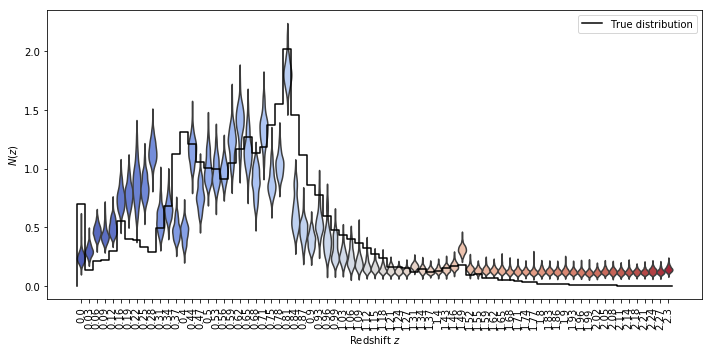

In [14]:
fbs_samples_ztm = np.load('bpz_DES_GOLD_Y1_ztm_4_post.npy')

binsize = (z_grid_coarse[1] - z_grid_coarse[0])
# Same but with type marginalized.
fig, axs = plt.subplots(1, 1, figsize=(10,5), sharex=False)
stacked_like = bpz_like_ztm[:,:,:].sum(axis=3).sum(axis=2).sum(axis=0)
stacked_like /= nobj
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)
fbs_samples_z /= binsize
# hist_noiseless_z = hist_noiseless_ztm.sum(axis=(1,2))
# hist_noiseless_z /= hist_noiseless_z.sum()
df = pd.DataFrame(fbs_samples_z[300:,:], columns=np.round(z_grid_coarse, decimals = 2))
t1 = sns.violinplot(data = df, width=1, scale_hue=False, scale='width', ax=axs,
              inner=None, palette="coolwarm", label=r'Recovered distribution')
t3 = axs.plot(np.concatenate(([z_grid_coarse[0]/binsize-0.5], z_grid_coarse/binsize+0.5)), 
            np.concatenate(([0], true_z)), color='k', lw=1.5, 
            drawstyle='steps', label=r'True distribution')

for tick in axs.get_xticklabels():
        tick.set_rotation(90)
axs.legend()
axs.set_ylabel(r'$N(z)$')
axs.set_xlabel(r'Redshift $z$')
fig.tight_layout()

In [15]:
means = np.zeros(fbs_samples_z.shape[0]-1)
width = np.zeros(fbs_samples_z.shape[0]-1)

for i in range(1,fbs_samples_z.shape[0]):
    means[i-1] = np.trapz(fbs_samples_z[i]*z_grid_coarse, z_grid_coarse, binsize)
    width[i-1] = np.trapz((z_grid_coarse-means[i-1])**2*fbs_samples_z[i], z_grid_coarse, binsize)

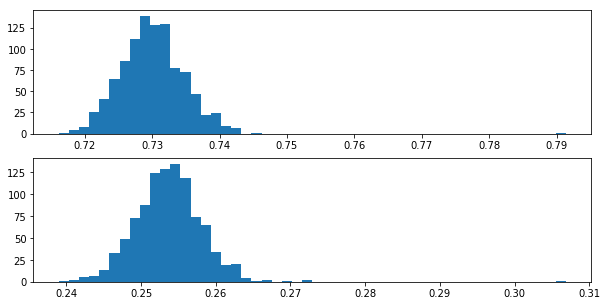

In [16]:
f, axes = plt.subplots(2,1, figsize = (10,5))

axes[0].hist(means, bins =50);
axes[1].hist(width, bins =50);